<a href="https://colab.research.google.com/github/TalhaOmi/-bengali-fake-news-using-bangla-bert-base/blob/main/(Main)_bengali_fake_news_using_bangla_bert_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install transformers
!pip install bnlp_toolkit
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 36.4 MB/s 
     |████████████████████████████████| 163 kB 70.1 MB/s 
     |████████████████████████████████| 6.6 MB 55.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.9 MB 1.2 MB/s 
     |████████████████████████████████| 1.3 MB 52.5 MB/s 
     |████████████████████████████████| 965 kB 57.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [4]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [5]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /60%/model_testing_auth.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /60%/model_testing_fake.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))

29208
780


In [6]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)



29988

In [7]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


********** Before ***************
২২২ রানের পুঁজি নিয়ে শেষ বল পর্যন্ত লড়াই করেছে বাংলাদেশ। সতীর্থদের লড়াকু মানসিকতায় মুগ্ধ মাশরাফী বিন মোর্ত্তজা। তবে স্পিনাররা আরো ভালো করলে অন্যরকম হতে পারতো ম্যাচের ফল। সেই সাথে মিডল অর্ডারের ব্যর্থতায় যথেষ্ট রানের পুঁজি সংগ্রহ সম্ভব হয়নি- বলছেন বাংলাদেশ অধিনায়ক। দান দান তিন দান। কথাটা বাংলাদেশের বেলায় খাটলো না। তৃতীয়বার ফাইনালে উঠে হতাশা নিয়ে মাঠ ছাড়তে হলো। ওপেনিং সমস্যা কাটিয়ে মাশরাফীর অনন্য সিদ্ধান্তে যে দুর্দান্ত শুরু, সেটা যদি ধরে রাখতে পারতেন মুশফিকরা তাহলে ম্যাচের চেহারা অন্যরকম হতো। বড় মঞ্চের তারকা মাহমুদুল্লাহ বড় ম্যাচেই ফ্লপ। স্বল্প পুজি নিয়ে বোলাররা যে শেষ বল পর্যন্ত নিয়ে যেতে পেরেছেন ম্যাচটাকে, তার কৃতিত্ব কেবল মাশরাফী একার। তবে, স্পিনার আরেকটু সাপোর্ট দিতে পারলে ভাল হতো বলে মনে করেন ম্যাশ। বারবার ফাইনালে উঠে হেরে যাচ্ছে বাংলাদেশ। কী যেন একটা বাধা হয়ে দাড়াচ্ছে বারবার। ক্যাপ্টেন ফ্যান্টাসটিক খুজে বের করতে চান কারণ। প্রতিপক্ষ নয়, বরং নিজেদের দিকেই বেশি নজর ছিল ভারতের। তবুও বাংলাদেশের ক্রিকেট যে অনেকটাই এগিয়েছে সেটা স্বীকার করছেন অধিনায়কও। ভা

In [8]:
import imblearn

In [9]:
from imblearn.over_sampling import RandomOverSampler

from imblearn.under_sampling import RandomUnderSampler

In [10]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [11]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [12]:
x= df.drop('label', axis=1)
y= df.label

In [13]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [14]:
y_train_resampled

0       0
1       0
2       0
3       0
4       0
       ..
1555    1
1556    1
1557    1
1558    1
1559    1
Name: label, Length: 1560, dtype: int64

In [15]:
df = X_train_resampled.join(y_train_resampled)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1560 non-null   int64 
 1   articleID   1560 non-null   int64 
 2   domain      1560 non-null   object
 3   date        1560 non-null   object
 4   category    1560 non-null   object
 5   headline    1560 non-null   object
 6   content     1560 non-null   object
 7   head        1560 non-null   object
 8   con         1560 non-null   object
 9   label       1560 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 122.0+ KB


In [17]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [18]:
len(train_df), len(test_df)

(1248, 312)

In [19]:
test_df.head()

,Unnamed: 0,articleID,domain,date,category,headline,content,head,con,label
972,16954,21466,independent24.com,2018-09-27 14:54:18,National,মধ্যপ্রাচ্যগামী ফ্লাইটের শিডিউল বিপর্যয়,আরো সংবাদ ইউএস বাংলা বিমানের চট্টগ্রামে জরুরী ...,মধ্যপ্রাচ্যগামী ফ্লাইটের শিডিউল বিপর্যয়,আরো সংবাদ ইউএস বাংলা বিমানের চট্টগ্রামে জরুরী ...,1
512,501,505,motikontho.wordpress.com,2015-07-29T15:02:46+00:00,Miscellaneous,সাকার নতুন রোল | দৈনিক মতিকণ্ঠ,কাজ চলে যায় যে কোনো ফুটোতেখাপ যদি খায় আকারনামে...,সাকার রোল দৈনিক মতিকণ্ঠ,যায় ফুটোতেখাপ খায় আকারনামেতে ফাকার জুড়ে লোকেমও...,0
1476,15969,20109,jagonews24.com,2018-09-26 20:35:19,Sports,মিঠুনের বিদায়ে ভাঙল জুটি,ইনিংসের পঞ্চম ওভারে মাত্র ১২ রানের বিদায়ে চাপে...,মিঠুনের বিদায়ে ভাঙল জুটি,ইনিংসের পঞ্চম ওভারে ১২ রানের বিদায়ে চাপে পড়ে য...,1
1396,10552,13380,prothomalo.com,2018-09-24 11:50:09,National,বিতর্কের এশিয়া কাপে বাংলাদেশের জয়,৭ থেকে ১২ সেপ্টেম্বর ভিয়েতনামের হানয়ে অনুষ্ঠিত...,বিতর্কের এশিয়া কাপে বাংলাদেশের জয়,৭ ১২ সেপ্টেম্বর ভিয়েতনামের হানয়ে অনুষ্ঠিত এশিয়...,1
290,145,147,channeldhaka.news,2019-02-14T16:33:32+00:00,Miscellaneous,ভূমিকম্প !! কেঁপে উঠছে ঢাকার আবাসিক হোটেলগুলো !,ShareTweetশহরজুড়ে মৃদু কাঁপুনি অনুভব করা যাচ্...,ভূমিকম্প কেঁপে উঠছে ঢাকার আবাসিক হোটেলগুলো,ShareTweetশহরজুড়ে মৃদু কাঁপুনি অনুভব খানিক বা...,0


In [20]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [21]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

# Define Model
 `Bert` stands for Bidirectional Encoder Representations from Transformers used in this experiment with two additional `Fully Connected` Layers. 
 
 For this experiment, [Bangla Bert](https://huggingface.co/sagorsarker/bangla-bert-base) pretrained model was used.

#### FC layers
- First Linear Layer: IO(768 -> 128)
- Second Linear Layer: IO(128 -> 2)

#### Additionals
- Activation Fuction: Relu
- Dropout: 20%
- Optimizer: AdamW
- Loss: CrossEntropyLoss
- Scheduler: StepLR

In [22]:
class NewsBert(nn.Module):

    def __init__(self, bert):
        super(NewsBert, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [23]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

In [24]:
# for param in bert.parameters():
#     param.requires_grad = False

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewsBert(bert)
model.to(device);

In [26]:
s = "আমি বাংলায় গান গাই। [SEP]"
t = tokenizer.encode_plus(s, return_tensors="pt").to(device)
print(t)
out = model(**t)
print(out)

{'input_ids': tensor([[  101,  2169,  2492,  9294,  2552, 13985,  1014,   102,   102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
tensor([[-0.0890, -0.0448]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [27]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Lets Train

In [28]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [29]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [40]:
epochs = 2
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [41]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_main_model1.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/2


  0%|          | 0/1248 [00:00<?, ?it/s]

	Train loss:0.474444.. 	Valid Loss:0.745018.. 	Accuracy: 85.2564
Epoch: 2/2


  0%|          | 0/1248 [00:00<?, ?it/s]

	Train loss:0.468998.. 	Valid Loss:0.746896.. 	Accuracy: 85.2564
Training completed in 5m 37s


In [32]:
training_acc1 = correct / total * 100
training_acc1

86.85897435897436

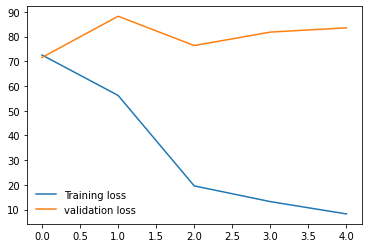

In [33]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

# Testing
To test this model, the left 15% data was used.

In [34]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_main_model1.pth", map_location = device))

<All keys matched successfully>

In [35]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [36]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       156
           1       0.85      0.85      0.85       156

    accuracy                           0.85       312
   macro avg       0.85      0.85      0.85       312
weighted avg       0.85      0.85      0.85       312



In [37]:
cf_matrix = confusion_matrix(all_labels, all_preds)  


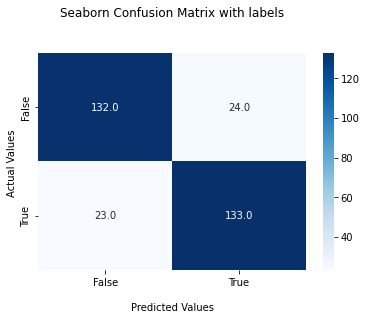

In [42]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt=".1f")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [39]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy1 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy1)
precision = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision)
recall = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall)
score = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score)

Accuracy: 0.849
Precision: 0.849
Recall: 0.849
F-Measure: 0.849
